## 1. Convert label studio format to splitted by domain coco dataset
<!-- ## 2. Prepare images: convert pdf page -> img by pdf2img.py
## 3. Create grids -->

In [1]:
import json
from tqdm import tqdm
import os
import fitz 
import re

In [2]:
with open('annotated_files.json') as f:
    docs = json.load(f)

docidx_by_domain = {}
for i, doc in enumerate(docs):
    domain = doc['data']['domain']
    if domain not in docidx_by_domain.keys():
        docidx_by_domain[domain] = []
    docidx_by_domain[domain].append(i)
    



In [3]:
def remove_punctuation(text):
    # Sử dụng biểu thức chính quy để loại bỏ các ký tự dấu câu
    return re.sub(r'[^\w\s]', '', text)

In [4]:
labeled_item= {
    'hung': {
        'start': 80706,
        'end': 80790,
        'labeled':[]
    },
    'truong': {
        'start': 80791,
        'end': 80875,
        'labeled':[]
    },
    'thuy': {
        'start': 80876,
        'end': 80960,
        'labeled':[]
    },

    'dang': {
        'start': 80969,
        'end': 81053,
        'labeled':[]
    },
    'vinh': {
        'start': 81054,
        'end': 81063,
        'labeled':[]
    },
}

In [5]:
domain_mapping = {}

for domain in os.listdir('./pdf/'):
    for file in tqdm(os.listdir(os.path.join('./pdf/',domain))):
        # Convert the PDF to images
        document = {
            "file_name": file,
            "domain": domain,
            "document": []
        }
        pdf_document = fitz.open(os.path.join('./pdf/',domain,file))
        file = file.replace('.pdf','')
        # Iterate through each page
        annotations =[{'result':[]}]
        for page_number in range(len(pdf_document)):
            file_name = f"{file}_page_{page_number}.jpg"
            domain_mapping[file_name] = domain

NotADirectoryError: [Errno 20] Not a directory: './pdf/20_2020_TTBTTTT_451586.pdf'

In [ ]:
with open('project-pages.json') as f:
    samples = json.load(f)
for sample in samples:
    for key in labeled_item.keys():
        if sample['id'] >= labeled_item[key]['start'] and sample['id'] <= labeled_item[key]['end']:
            domain = 'None'
            image_name = remove_punctuation(unidecode(os.path.basename(sample['data']['image'].replace('%2C',',').split('/')[-1].replace('.jpg',''))).replace(' ', '_'))
            domain = "None" if image_name+'.jpg' not in domain_mapping else domain_mapping[image_name+'.jpg']
            labeled_item[key]['labeled'].append(
                {**sample,
                 'domain': domain
                }
            )


In [ ]:
import matplotlib

### Thống kê số lượng đã gán theo Annotator

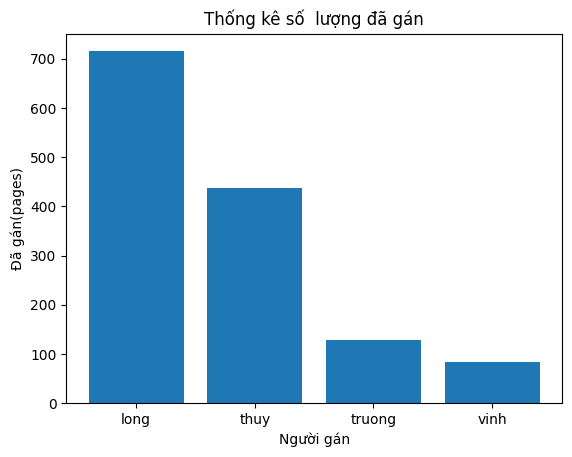

In [ ]:
import matplotlib.pyplot as plt

annotators = labeled_item.keys()
# Data
categories = list(annotators)
values = [len(labeled_item[annotator]['labeled']) for annotator in annotators]

# Plotting
plt.bar(categories, values)

# Adding labels and title
plt.xlabel('Người gán')
plt.ylabel('Đã gán(pages)')
plt.title('Thống kê số  lượng đã gán')

# Displaying the plot
plt.show()

In [ ]:
sum(values)

1365

In [ ]:
labeled_by_type={}
for key in labeled_item.keys():
    label={}
    annotations = labeled_item[key]['labeled']
    for annotation in annotations:
        labeleds = annotation['annotations'][0]['result']
        for labeled in labeleds:
            if len(labeled['value']['rectanglelabels'])==0:
                continue
            if labeled['value']['rectanglelabels'][0] in label:
                label[labeled['value']['rectanglelabels'][0]]+=1
            else:
                label[labeled['value']['rectanglelabels'][0]]=1
    print(label)
    labeled_by_type[key] =label


{'title': 2458, 'text': 5686, 'useless': 210, 'table': 374, 'figure': 74}
{'title': 1628, 'text': 3235, 'figure': 45, 'useless': 90, 'table': 229}
{'useless': 18, 'text': 1053, 'title': 540, 'figure': 22, 'table': 64}
{'useless': 26, 'text': 607, 'table': 42, 'title': 301, 'figure': 16}


In [ ]:
print(labeled_by_type['vinh'])

{'useless': 26, 'text': 607, 'table': 42, 'title': 301, 'figure': 16}


In [ ]:
total = {}
for key in labeled_by_type:
    for label in labeled_by_type[key].keys():
        if label in total:
            total[label] += labeled_by_type[key][label]
        else:
            total[label] = labeled_by_type[key][label]

In [ ]:
total

{'title': 4927, 'text': 10581, 'useless': 344, 'table': 709, 'figure': 157}

### Thống kê số lượng nhãn theo domain

In [ ]:
labeled_by_domain ={}
for key in labeled_item.keys():
    label={}
    annotations = labeled_item[key]['labeled']
    for annotation in annotations:
        domain = annotation['domain']
        if domain not in labeled_by_domain:
            labeled_by_domain[domain] = []
        else:
            labeled_by_domain[domain]+=[annotation]
        labeleds = annotation['annotations'][0]['result']
        

In [ ]:
labeled_by_domain['bank'][0]['data']['image']

'/data/local-files/?d=documents/IB_BIDV_Omni_HDSD_Med_page_64.jpg'

### training test split

In [ ]:
import random
import shutil
random.seed = 43
split = 0.7

In [ ]:
trainset =[]
testset = []
for domain in labeled_by_domain.keys():
    samples = labeled_by_domain[domain]
    random.shuffle(samples)
    splitter = int(split*len(samples))
    train_samples = samples[:splitter]
    test_samples = samples[splitter:]
    trainset+=train_samples
    testset+=test_samples

print(len(trainset),len(testset))

951 409


In [ ]:
# copy images file
idx = 0
images = []
images_id = {}
annotations =[]
categories =[{'id': 0,
            'name':"text"},
            {'id': 1,
            'name':"title"},
            {'id': 2,
            'name':"useless"},
            {'id': 3,
            'name':"table"},
            {'id': 4,
            'name':"figure"}]
categories_id = {c['name']: c['id'] for c in categories}
for sample in trainset:
    try:
        image_name = standardize_filename(sample['data']['image'])
        grid_name = image_name.replace('.jpg','.pdf.pkl')
        shutil.copyfile(f'images/{image_name}',f'dataset_v1/train/{image_name}')
        shutil.copyfile(f'grid/{grid_name}',f'dataset_v1/grid/{grid_name}')
        original_width = sample['annotations'][0]['result'][0]['original_width']
        original_height = sample['annotations'][0]['result'][0]['original_height']
        images.append({
            'id': sample['id'],
            'file_name': image_name,
            'height': original_height,
            'width': original_width
        })
        for annot in sample['annotations'][0]['result']:
            x = annot['value']['x']
            y = annot['value']['y']
            box_width = annot['value']['width']
            box_height = annot['value']['height']
            x_min = x/100*original_width
            y_min = y/100*original_height
            box_width = box_width/100*original_width
            box_height = box_height/100*original_height
            bbox = [x_min, y_min,box_width, box_height]
            try:
                annotations.append(
                    {
                        "bbox": bbox,
                        "bbox_mode": 1,
                        "category_id": categories_id[annot['value']['rectanglelabels'][0]],
                        "image_id": sample['id'],
                        "id": idx,
                        "iscrowd": 0,
                        "area": box_width*box_height
                    }
                )
            except:
                print(sample['id'])
            idx+=1
    except:
        print(f'fail load image {image_name}')

71903
fail load image Cap2Bnhat2BBieu2Bphi2Btheo2Bchinh2Bsach2Bmien2Bgiam2Bphi2Btai2Bvan2Bban2B114262B2821112229_page_7.jpg
fail load image 14_2022_NDCP_482325_28129_page_54.jpg
fail load image 14_2022_NDCP_482325_28129_page_21.jpg
fail load image 14_2022_NDCP_482325_28129_page_28.jpg
fail load image 14_2022_NDCP_482325_28129_page_11.jpg
fail load image Cap2Bnhat2BBieu2Bphi2Btheo2Bchinh2Bsach2Bmien2Bgiam2Bphi2Btai2Bvan2Bban2B114262B2821112229_page_2.jpg
fail load image HAN2BMUC2BGIAO2BDICH2BCAC2BDICH2BVU2BCAP2BNHAT2B011222_page_4.jpg
fail load image 14_2022_NDCP_482325_28129_page_39.jpg
fail load image 14_2022_NDCP_482325_28129_page_22.jpg
fail load image 14_2022_NDCP_482325_28129_page_31.jpg
fail load image 14_2022_NDCP_482325_28129_page_16.jpg
fail load image BIEU2BPHI2BDICH2BVU2BBAO2BLANH2BTHEO2BQD2B225_page_4.jpg
fail load image 14_2022_NDCP_482325_28129_page_3.jpg
fail load image BIEU2BPHI2BDICH2BVU2BBAO2BLANH2BTHEO2BQD2B225_page_1.jpg
fail load image BIEU2BDICH2BVU2BCHUYEN2BTIEN2

In [ ]:
VER_DIR = 'dataset_v1'

In [ ]:

with open(f'{VER_DIR}/train.json', 'w') as f:
    json.dump({'images': images,
               'annotations': annotations,
               'categories': categories}, f, indent=4)

In [ ]:
# copy images file
idx = 0
images = []
images_id = {}
annotations =[]
categories =[{'id': 0,
            'name':"text"},
            {'id': 1,
            'name':"title"},
            {'id': 2,
            'name':"useless"},
            {'id': 3,
            'name':"table"},
            {'id': 4,
            'name':"figure"}]
categories_id = {c['name']: c['id'] for c in categories}
for sample in testset:
    try:
        image_name = standardize_filename(sample['data']['image'])
        grid_name = image_name.replace('.jpg','.pdf.pkl')
        shutil.copyfile(f'images/{image_name}',f'dataset_v1/val/{image_name}')
        shutil.copyfile(f'grid/{grid_name}',f'dataset_v1/grid/{grid_name}')
        original_width = sample['annotations'][0]['result'][0]['original_width']
        original_height = sample['annotations'][0]['result'][0]['original_height']
        images.append({
            'id': sample['id'],
            'file_name': image_name,
            'height': original_height,
            'width': original_width
        })
        for annot in sample['annotations'][0]['result']:
            x = annot['value']['x']
            y = annot['value']['y']
            box_width = annot['value']['width']
            box_height = annot['value']['height']
            x_min = x/100*original_width
            y_min = y/100*original_height
            box_width = box_width/100*original_width
            box_height = box_height/100*original_height
            bbox = [x_min, y_min,box_width, box_height]
            try:
                annotations.append(
                    {
                        "bbox": bbox,
                        "bbox_mode": 1,
                        "category_id": categories_id[annot['value']['rectanglelabels'][0]],
                        "image_id": sample['id'],
                        "id": idx,
                        "iscrowd": 0,
                        "area": box_width*box_height
                    }
                )
            except:
                print(sample['id'])
            idx+=1
    except:
        print(f'fail load image {image_name}')

fail load image 14_2022_NDCP_482325_28129_page_46.jpg
fail load image 14_2022_NDCP_482325_28129_page_40.jpg
fail load image BIEU2BPHI2BDICH2BVU2BBAO2BLANH2BTHEO2BQD2B225_page_3.jpg
fail load image Cap2Bnhat2BBieu2Bphi2Btheo2Bchinh2Bsach2Bmien2Bgiam2Bphi2Btai2Bvan2Bban2B114262B2821112229_page_0.jpg
fail load image 14_2022_NDCP_482325_28129_page_43.jpg
fail load image 14_2022_NDCP_482325_28129_page_36.jpg
fail load image Cap2Bnhat2BBieu2Bphi2Btheo2Bchinh2Bsach2Bmien2Bgiam2Bphi2Btai2Bvan2Bban2B114262B2821112229_page_4.jpg


In [ ]:

with open(f'{VER_DIR}/val.json', 'w') as f:
    json.dump({'images': images,
               'annotations': annotations,
               'categories': categories}, f, indent=4)